In [10]:
import numpy as np
import pandas as pd
from logRegression import LogRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import sys
sys.path.append('./models/')
import warnings
warnings.simplefilter("ignore")

In [2]:
def cross_val_score(model, X, y):
    acc_scores = []
    prec_scores = []
    roc_scores = []
    
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)
        prec_score = precision_score(y_test, y_pred, pos_label='positive', average='micro')
        roc_score = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), multi_class='ovr')
        acc_scores.append(acc_score)
        prec_scores.append(prec_score)
        roc_scores.append(roc_score)

    score = np.mean(acc_scores), np.mean(prec_scores), np.mean(roc_scores)
    return score

In [9]:
data = pd.read_csv('models/StudentsPerformance.csv.xls')

{0: "associate's degree", 1: "bachelor's degree", 2: 'high school', 3: "master's degree", 4: 'some college', 5: 'some high school'}


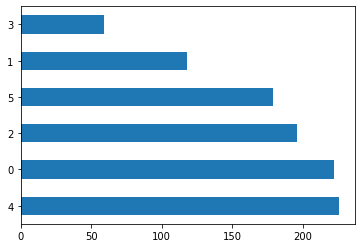

In [14]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(data['parental level of education']))
mapped_education.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

In [15]:
categorical_columns = data.columns[data.dtypes == 'object'].union(['gender'])
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,0,1,1,1,1,72,72,74
1,0,2,4,1,0,69,90,88
2,0,1,3,1,1,90,95,93
3,1,0,0,0,1,47,57,44
4,1,2,4,1,1,76,78,75


In [16]:
X, Y = data.drop(['test preparation course'], axis=1), data['test preparation course']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [17]:
def print_error_validation(accuracy, precission, roc_auc):
    print('Ошибки на кросс валидации:')
    print(f'Accuracy  = {accuracy}')
    print(f'Precision = {precision}')
    print(f'Roc auc   = {roc_auc}')
    
def retrain(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    
    y_pred_test = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    
    acc = accuracy_score(y_pred_train, y_train), accuracy_score(y_pred_test, y_test)
    
    prec = precision_score(y_pred_train, y_train, pos_label='positive', average='micro'), precision_score(y_pred_test, y_test, pos_label='positive', average='micro')
    
    roc = roc_auc_score(pd.get_dummies(y_train), pd.get_dummies(y_pred_train), multi_class='ovr'), roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred_test), multi_class='ovr')
    
    print('Ошибки на выборках')
    print('            Train                   Test')
    print(f'Accuracy  = {acc[0]}  |  {acc[1]}')
    print(f'Precision = {prec[0]}  |  {prec[1]}')
    print(f'Roc auc   = {roc[0]}  |  {roc[1]}')
    
    
def search_parametrs_C(C_list):
    best_C = None
    best_roc = -10
    
    for C in C_list:
        model = LogRegression(C=C)
        accuracy, precision, roc_auc = cross_val_score(model, X.values, Y.values)
        if roc_auc > best_roc:
            best_C = C
    return best_C

# Логистическая регрессия

In [18]:
model = LogRegression()

In [19]:
accuracy, precision, roc_auc = cross_val_score(model, X.values, Y.values)
print_error_validation(accuracy, precision, roc_auc)

Ошибки на кросс валидации:
Accuracy  = 0.58
Precision = 0.58
Roc auc   = 0.5059324776183799


In [20]:
retrain(model, x_train.values, x_test.values, y_train.values, y_test.values)

Ошибки на выборках
            Train                   Test
Accuracy  = 0.6537313432835821  |  0.6181818181818182
Precision = 0.6537313432835821  |  0.6181818181818182
Roc auc   = 0.5  |  0.5


# Логистическая регрессия с Sklearn

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
scoring = ['precision_micro', 'roc_auc','accuracy']
scoring_test = ['test_accuracy','test_precision_micro','test_roc_auc']

In [23]:
logreg = LogisticRegression(C=1e5)
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
print(f'Ошибка на выборках:\nAccuracy = {accuracy_score(y_test, y_pred)}')

Ошибка на выборках:
Accuracy = 0.706060606060606


In [24]:
logreg = LogisticRegressionCV(cv=5, multi_class='ovr', random_state=0).fit(x_train, y_train)
y_pred = logreg.predict(x_test)

print(f'Ошибки на кросс валидации:\nAccuracy = {accuracy_score(y_test, y_pred)} ')

Ошибки на кросс валидации:
Accuracy = 0.7212121212121212 


In [25]:
retrain(logreg, x_train.values, x_test.values, y_train.values, y_test.values)

Ошибки на выборках
            Train                   Test
Accuracy  = 0.7388059701492538  |  0.7212121212121212
Precision = 0.7388059701492538  |  0.7212121212121212
Roc auc   = 0.6785939222169737  |  0.6758870214752568


In [26]:
mobile_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   gender                       1000 non-null   int64
 1   race/ethnicity               1000 non-null   int64
 2   parental level of education  1000 non-null   int64
 3   lunch                        1000 non-null   int64
 4   test preparation course      1000 non-null   int64
 5   math score                   1000 non-null   int64
 6   reading score                1000 non-null   int64
 7   writing score                1000 non-null   int64
dtypes: int64(8)
memory usage: 62.6 KB
